In [3]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

tensor = torch.tensor

# Meanshift

In [323]:
a = tensor([[0, 0], [1, 0], [3, 3], [9, 10]], dtype=torch.float)
#a = torch.rand((100, 2))*100

In [310]:
print(a)
a.shape

tensor([[ 0.,  0.],
        [ 1.,  0.],
        [ 3.,  3.],
        [ 9., 10.]])


torch.Size([4, 2])

In [311]:
# dists = torch.empty(a.shape[0], a.shape[0])
# for pi in range(a.shape[0]):
#     p1 = a[pi]
#     for opi in range(a.shape[0]):
#         p2 = a[opi]
#         dist = ((p2 - p1)**2).sum().sqrt()
#         dists[pi, opi] = dist

# dists

tensor([[-7.9654e-14,  4.5835e-41, -7.9654e-14,  4.5835e-41],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  7.7052e+31,  7.2148e+22],
        [ 1.5766e-19,  1.0256e-08,  1.0501e-05,  3.1128e+12]])

In [312]:
diffs = a - a.unsqueeze(1)
diffs = diffs**2
dists = diffs.sum(-1).sqrt()
dists

tensor([[ 0.0000,  1.0000,  4.2426, 13.4536],
        [ 1.0000,  0.0000,  3.6056, 12.8062],
        [ 4.2426,  3.6056,  0.0000,  9.2195],
        [13.4536, 12.8062,  9.2195,  0.0000]])

In [313]:
def falloff(x):
    return 1.0 / torch.exp(x/2)

In [314]:
fall = falloff(dists)
print(fall)
print(fall.shape, "\n")

sums = fall.sum(-1)
print(sums)
print(sums.shape, "\n")

tensor([[1.0000, 0.6065, 0.1199, 0.0012],
        [0.6065, 1.0000, 0.1648, 0.0017],
        [0.1199, 0.1648, 1.0000, 0.0100],
        [0.0012, 0.0017, 0.0100, 1.0000]])
torch.Size([4, 4]) 

tensor([1.7276, 1.7730, 1.2947, 1.0128])
torch.Size([4]) 



In [315]:
fall@a / sums.unsqueeze(-1)

tensor([[0.5655, 0.2151],
        [0.8513, 0.2883],
        [2.5137, 2.3941],
        [8.9173, 9.9030]])

In [316]:
norm = fall / sums.unsqueeze(-1)
norm@a

tensor([[0.5655, 0.2151],
        [0.8513, 0.2883],
        [2.5137, 2.3941],
        [8.9173, 9.9030]])

tensor([[1.0000, 0.9916, 0.4671, 0.0021],
        [0.9916, 1.0000, 0.4708, 0.0021],
        [0.4671, 0.4708, 1.0000, 0.0044],
        [0.0021, 0.0021, 0.0044, 1.0000]])


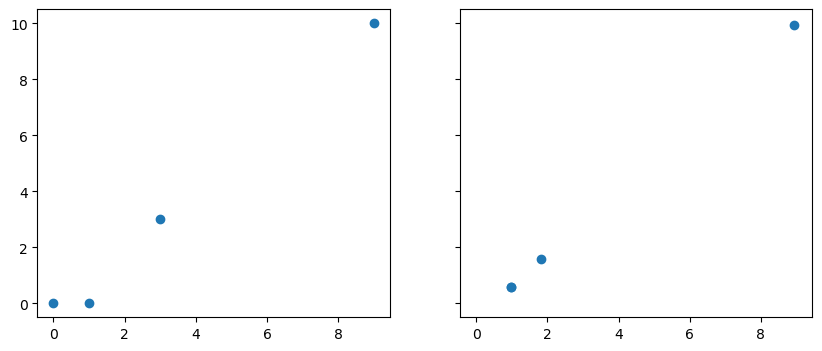

In [317]:
def meanshift(P):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    ax = axs[0]
    ax.scatter(P[:, 0], P[:, 1])

    for _ in range(5):
        diffs = P - P.unsqueeze(1)
        diffs = diffs**2
        dists = diffs.sum(-1).sqrt()

        fall = falloff(dists)
        sums = fall.sum(-1)
        scaled_ps = (fall@a)
        P = scaled_ps / sums.unsqueeze(-1)

    ax: plt.Axes = axs[1]
    ax.set_xlim(axs[0].get_xlim())
    ax.scatter(P[:, 0], P[:, 1])

    print(fall)

meanshift(a)

In [320]:
def meanshift(P):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    xlim = ylim = None
   
    def anim_cb(frame):
        nonlocal P, xlim, ylim

        if not frame:
            ax.clear()
            ax.scatter(P[:, 0], P[:, 1])
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()
            
        else:
            diffs = P - P.unsqueeze(1)
            diffs = diffs**2
            dists = diffs.sum(-1).sqrt()

            fall = falloff(dists)
            sums = fall.sum(-1)
            scaled_ps = (fall@a)
            P = scaled_ps / sums.unsqueeze(-1)

            ax.clear()
            ax.scatter(P[:, 0], P[:, 1])
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)

    ani = FuncAnimation(fig, anim_cb, frames=5)
    plt.close()
    return ani

ani = meanshift(a)

In [321]:
HTML(ani.to_jshtml(60))

# DBSCAN

In [5]:
from sklearn.datasets import make_moons

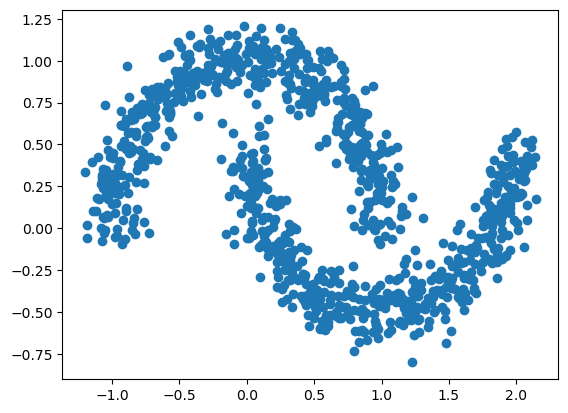

In [6]:
pts = tensor(make_moons(1000, noise=0.1)[0], dtype=torch.float)
plt.scatter(pts[:, 0], pts[:, 1])

In [8]:
eps = 0.1
min_pts = 4

label_next = 0
labels = torch.empty(pts.shape[0], dtype=torch.int) 

def find_neighbors(pts, pti):
    dists = ((pts[pti] - pts)**2).sum(-1).sqrt()
    eps_mask = dists < eps
    eps_mask[pti] = False
    ind = eps_mask.nonzero().view(-1)
    return ind.shape[0], ind

def set_label(lbls, lbi, lbl, cb=None):
    if cb: cb()
    lbls[lbi] = lbl

def dbscan(pts, cb=None):
    global label_next
    label_next = 1
    labels.zero_()

    for i in range(len(pts)):
        if labels[i] != 0: continue
        
        neighbors_num, neighbors = find_neighbors(pts, i)
        if neighbors_num < min_pts: continue

        label = label_next
        label_next += 1

        set_label(labels, i, label, cb)
        to_visit = [neighbors]
        while to_visit:
            neighbors = to_visit.pop()
            for ni in neighbors:
                if labels[ni] != 0: continue
                set_label(labels, ni, label, cb)

                neighbors_num, neighbors = find_neighbors(pts, ni)
                if neighbors_num >= min_pts: 
                    to_visit.append(neighbors)


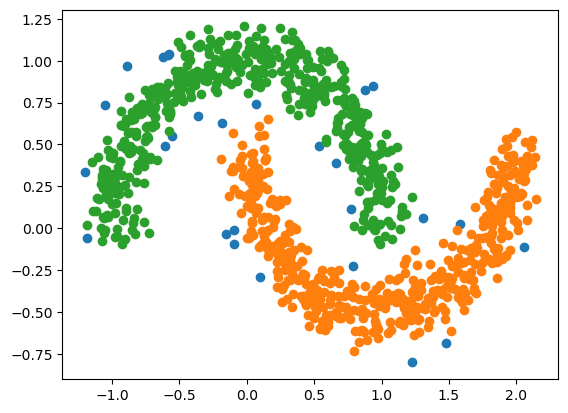

In [9]:
dbscan(pts)

for i in range(label_next):
    mask = labels == i
    pts_sub = pts[mask]
    plt.scatter(pts_sub[:, 0], pts_sub[:, 1])
plt.show()

In [10]:
from matplotlib.animation import ArtistAnimation

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
artists = []

def save_frame():
    ax.set_prop_cycle(None) # Resets the color pallette, otherwise every frame gets new colors
    plots = []
    for i in range(label_next):
        mask = labels == i
        pts_sub = pts[mask]
        sc = ax.scatter(pts_sub[:, 0], pts_sub[:, 1])
        plots.append(sc)
    artists.append(plots) # Have to append an array even if you have only one scatter plot!!!

anim_counter = 0 # Accumulates updates before saving a frame
def anim_cb():
    global anim_counter

    if anim_counter % 100 == 0:
        save_frame()
    anim_counter += 1


dbscan(pts, anim_cb) # Function that does work and will call us back at anim_cb
save_frame() # Save last frame too

ani = ArtistAnimation(fig, artists)
plt.close()

In [11]:
HTML(ani.to_jshtml(10))

In [211]:
ani.save("dbscan.mp4", fps=10)